Notebook objective: Train & test mixed effects linear model. Goal is to compare performance, SHAP values & fixed effects with GPB.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features, groupings and target
X = df.drop(["life_expectancy", "country", "year"], axis = 1)
G = df[["country", "year"]]
y = df.life_expectancy

In [6]:
# Create cv splitter
cv = GroupKFold(n_splits = 4)

In [7]:
scaler = MinMaxScaler()

## Testing & diagnostics

In [8]:
# Initialize lists to store validation results
train_list = []
val_list = []
preds_list = []
resids_list = []
fitted_list = []
fitres_list = []
scores_mse = []
scores_rmse = []
scores_mape = []

In [9]:
# Perform crossvalidation
for i, (train_index, val_index) in enumerate(cv.split(X = X, groups = G.country)):

    # Split train - val
    X_train, G_train, y_train = X.iloc[train_index, ], G.iloc[train_index, ], y[train_index]
    X_val, G_val, y_val = X.iloc[val_index, ], G.iloc[val_index, ], y[val_index]

    # Preprocess features
    X_train = scaler.fit_transform(X_train, y_train)
    X_val = scaler.transform(X_val)

    # Add intercept
    X_train = np.hstack(
        (X_train, np.ones((len(X_train), 1)))
    )
    X_val = np.hstack(
        (X_val, np.ones((len(X_val), 1)))
    )

    # Train mixed effects model
    train = gpb.Dataset(X_train, y_train)
    val = gpb.Dataset(X_val, y_val)

    gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

    gp_model.fit(X = X_train, y = y_train, params = {"std_dev": True})

    # Save actual values
    train_list.append(y_train)
    val_list.append(y_val)

    # Make predictions on test data
    preds = gp_model.predict(X_pred = X_val, group_data_pred = G_val, predict_var = True)["mu"]
    preds_list.append(preds)

    # Calculate prediction residuals
    resids = y_val - preds
    resids_list.append(resids)

    # Get fitted values
    fitted = gp_model.predict(X_pred = X_train, group_data_pred = G_train, predict_var = True)["mu"]
    fitted_list.append(fitted)

    # Get fitted residuals
    fitted_resids = y_train - fitted
    fitres_list.append(fitted_resids)

    # Calculate scores
    mse = mean_squared_error(y_val, preds)
    scores_mse.append(mse)

    rmse = mean_squared_error(y_val, preds, squared = False)
    scores_rmse.append(rmse)

    mape = mean_absolute_percentage_error(y_val, preds)
    scores_mape.append(mape)

In [10]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(np.mean(scores_mse), 4))

print("RMSE:")
print(round(np.mean(scores_rmse), 4))

print("MAPE:")
print(round(np.mean(scores_mape), 4))

MSE:
34.7144
RMSE:
5.8819
MAPE:
0.0726


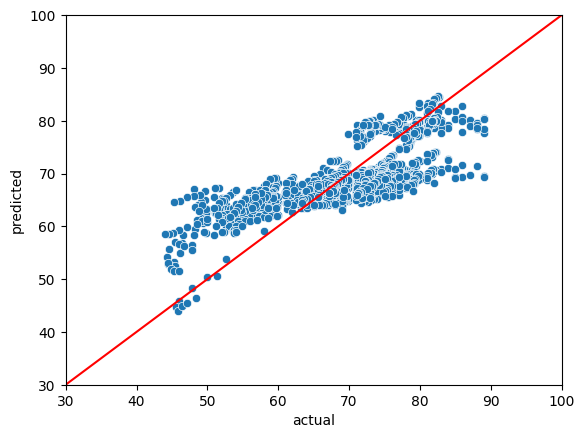

In [11]:
# Plot predicted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(val_list).ravel(),  
    y = np.concatenate(preds_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

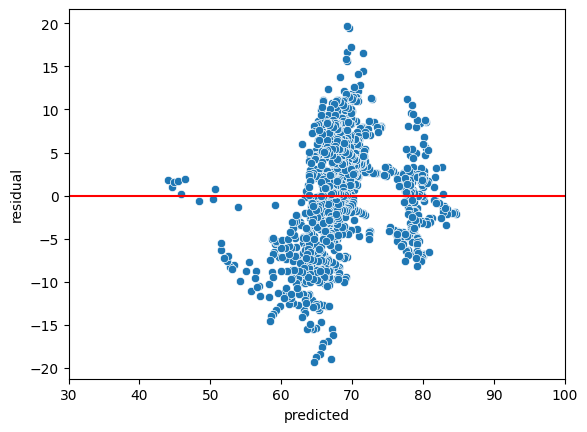

In [12]:
# Predicted vs residual
_ = sns.scatterplot(
    x = np.concatenate(preds_list).ravel(), 
    y = np.concatenate(resids_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

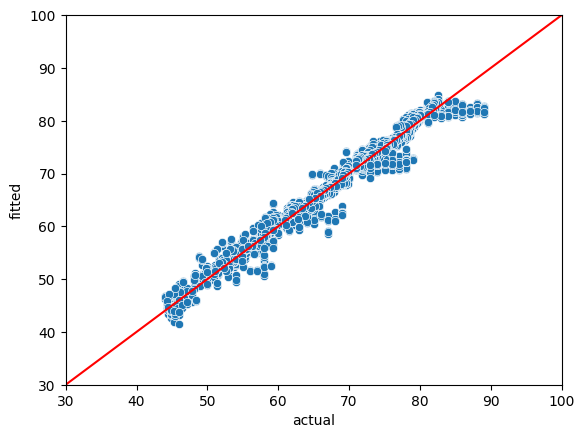

In [13]:
# Plot fitted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(train_list).ravel(),  
    y = np.concatenate(fitted_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

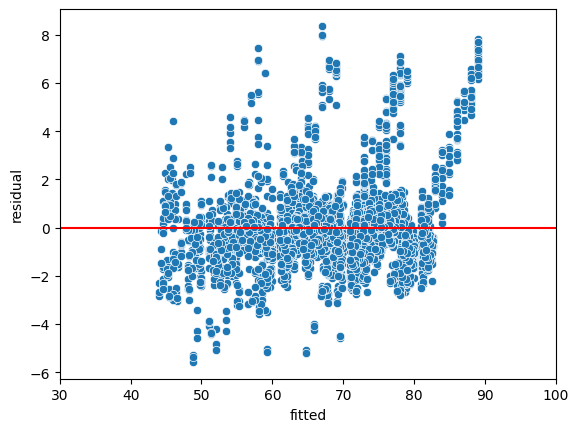

In [14]:
# Plot fitted vs. residual
_ = sns.scatterplot(
    x = np.concatenate(train_list).ravel(), 
    y = np.concatenate(fitres_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

## Inference

In [15]:
# Prepare data for final model
X_scaled = scaler.fit_transform(X, y)
X_scaled = np.hstack(
        (X_scaled, np.ones((len(X_scaled), 1)))
)
cols = X.columns.values.tolist()
cols.append("intercept")
X_scaled = pd.DataFrame(X_scaled, columns = cols)
train = gpb.Dataset(X_scaled, y)

In [16]:
# Train final model
gp_model = gpb.GPModel(
        group_data = G,
        likelihood = "gaussian",
        seed = random_state
    )

gp_model.fit(X = X_scaled, y = y, params = {"std_dev": True})

In [17]:
gp_model.summary()

Model summary:
     Log-lik         AIC         BIC
-3541.700000 7123.400000 7231.560000
Nb. observations: 1649
Nb. groups: 133 (country), 16 (year)
-----------------------------------------------------
Covariance parameters (random effects):
              Param.  Std. dev.
Error_term  2.803500   0.102300
country    33.895700   4.193400
year        0.559200   0.220800
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                    Param.  Std. dev.    z value  P(>|z|)
alcohol                          -1.190800   0.562400  -2.117500 0.034200
percentage_expenditure           -1.371500   2.321500  -0.590800 0.554700
hepatitis_b                       0.395000   0.236400   1.671000 0.094700
measles                          -0.632800   0.845300  -0.748700 0.454000
bmi                               0.086500   0.257200   0.336500 0.736500
polio                            -0.026100   0.251300  -0.104000 0.917200
total_exp

In [18]:
# Get model parameters for SHAP
coefs = gp_model.get_coef().iloc[:-1, :-1].values.flatten()
intercept = gp_model.get_coef().iloc[:-1, -1].values

In [19]:
# Get data parameters for SHAP
X_train_no_intercept = X_scaled.drop("intercept", axis = 1)
means = X_train_no_intercept.mean().values
covs = X_train_no_intercept.cov().values

In [20]:
# Get SHAP values
explainer = shap.LinearExplainer(
    (coefs, intercept), 
    (means, covs)
)
explainer.expected_value = explainer.expected_value[0] # To fix slicing issue with some SHAP plots
shap_values = explainer(X_train_no_intercept)

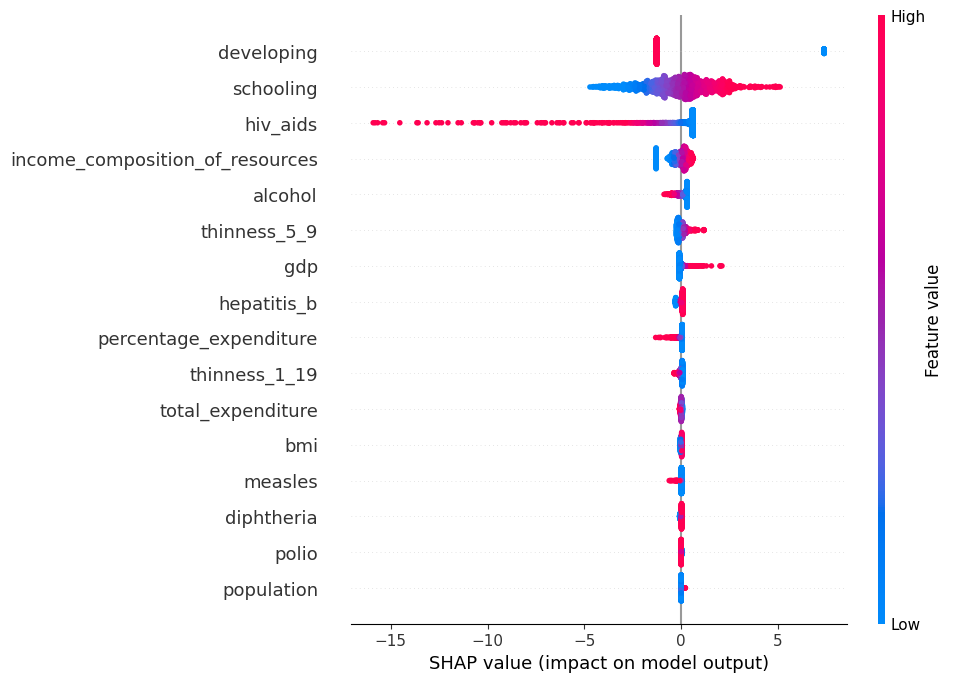

In [21]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

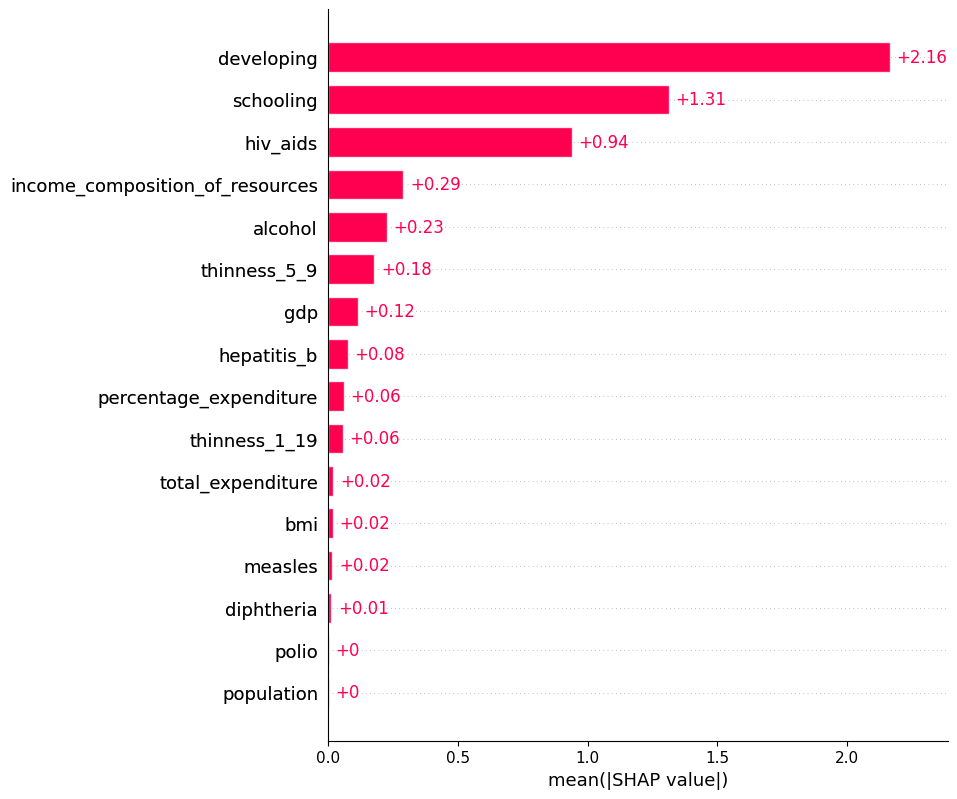

In [22]:
shap.plots.bar(shap_values, max_display = 20)